In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from fedland.utils import load_all_training_results, get_experiment_description, plot_results_overview, plot_client_info
from sklearn.linear_model import LinearRegression

## Analyze Generalizability
Things tried:
- Validation Acc alone and (train acc - test acc)
- Validation Loss and (train loss - test loss)
TODO:
- Pull in gini index and other client level stats

In [4]:
df = load_all_training_results(results_path="../results", ignore_validate=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23210 entries, 0 to 23209
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   index                        23210 non-null  int64         
 1   epoch                        23210 non-null  int64         
 2   learning_rate                23210 non-null  float64       
 3   batch_size                   23210 non-null  int64         
 4   len_train_indices            23210 non-null  int64         
 5   len_test_indices             23210 non-null  int64         
 6   momentum                     23210 non-null  float64       
 7   train_loss                   23210 non-null  float64       
 8   train_accuracy               23210 non-null  float64       
 9   test_loss                    23210 non-null  float64       
 10  test_accuracy                23210 non-null  float64       
 11  path_norm                    23210 non-nu

In [ ]:
# df_last_epoch = df.loc[df.groupby('experiment_id')['epoch'].idxmax()]
df_train = df.copy()
df_train = df_train[df_train.groupby('experiment_id')['epoch'].transform('max') == df_train['epoch']]
df_train["pct_change_path_norm_round"] = (
    (df_train["path_norm"] - df_train["global_path_norm"]) / df_train["global_path_norm"].abs()
)
df_train = df_train[df_train["iteration"] < 20] # NOTE checking the first 20 iterations
print(df_train.shape)
df_train[["len_train_indices", "path_norm", "pct_change_path_norm_round", "iteration"]].describe()

(597, 20)


,len_train_indices,path_norm,pct_change_path_norm_round,iteration
count,597.000000,597.000000,597.000000,597.000000
mean,11465.562814,123.447676,2.475667,10.356784
std,7245.750785,79.121881,2.738865,4.857535
min,500.000000,7.592847,-0.399287,3.000000
25%,7000.000000,14.570710,0.143375,6.000000
50%,10000.000000,139.140371,0.799464,10.000000
75%,16666.000000,180.920001,5.095172,15.000000
max,25000.000000,293.088777,12.357964,18.000000


In [62]:
x_vars = ["pct_change_path_norm_round", "experiment_id"]
# Y = "test_accuracy"
Y = "test_loss"
df_train['experiment_id'] = df_train['experiment_id'].astype('category')
df_train['client_index'] = df_train['client_index'].astype('category')

# X = df_train[x_vars]
X = pd.get_dummies(df_train[x_vars], columns=["experiment_id"], drop_first=False)
# y = df_train[Y] / 100
y = df_train[Y]

model = LinearRegression()
model.fit(X, y)
print(f"Y variable = {Y}")
print("Model Coefficients:")
for var, coef in zip(X.columns, model.coef_):
    print("---")
    if 'experiment_id_' in var:
        uuid = var.split('_')[2]
        print(get_experiment_description(experiment_id=uuid, results_path="../results"))
    print(f"{var}: {coef:.4f}")

print(f"Intercept: {model.intercept_:.4f}")

Y variable = test_loss
Model Coefficients:
---
pct_change_path_norm_round: 0.0219
---
ResNet CIFAR-10, 2 clients non-IID Imbalanced resnet fedavg
experiment_id_01960312-13a0-4f41-9e14-31508c3c02ba: 0.1301
---
CIFAR_FEDNET CIFAR-10, 2clients IID Balanced FedAdam
experiment_id_176b58e9-aace-4cbc-b7dc-8dba88af1bff: -0.2733
---
CIFAR_FEDNET CIFAR-10, 2 clients IID Balanced FedAvg
experiment_id_2bcc3999-3677-4989-a7eb-32639b83c165: -0.2326
---
CIFAR_FEDNET CIFAR-10, 2Clients Non-IID Balanced FedAdam
experiment_id_386b3021-3e83-4f5a-805b-3cdfcadb2489: -0.4195
---
CIFAR_FEDNET CIFAR-10, 2Clients IID Imbalaced FedAdam
experiment_id_3991aac2-cc3c-4405-b26f-e2896394190a: -0.2193
---
Resnet CIFAR-10, 5 clients, non-IID, balanced, fedopt
experiment_id_3f6c270c-ff3d-4c1d-a01c-3359312cd3c4: -0.0801
---
Resnet CIFAR-10, 5 clients, non-IID, balanced, fedavg
experiment_id_410ad360-b445-4ae8-b224-6f997845a9b1: -0.0324
---
Resnet CIFAR-10, 5 clients, IID, imbalanced, fedopt
experiment_id_4b3a8ef9-c2ee-4a

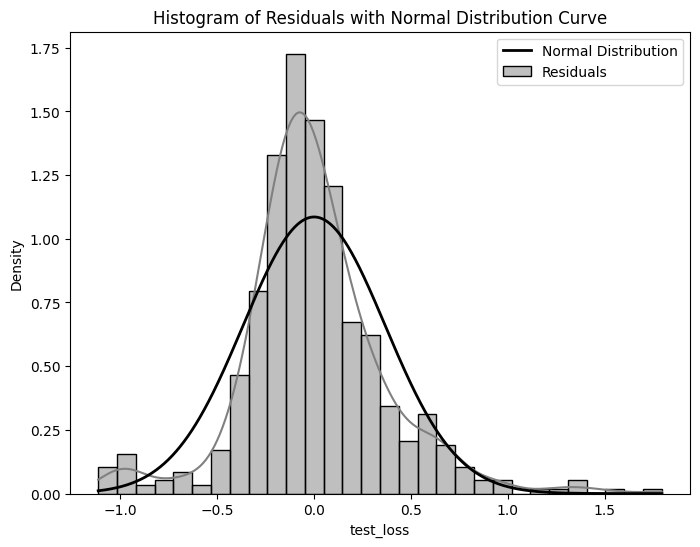

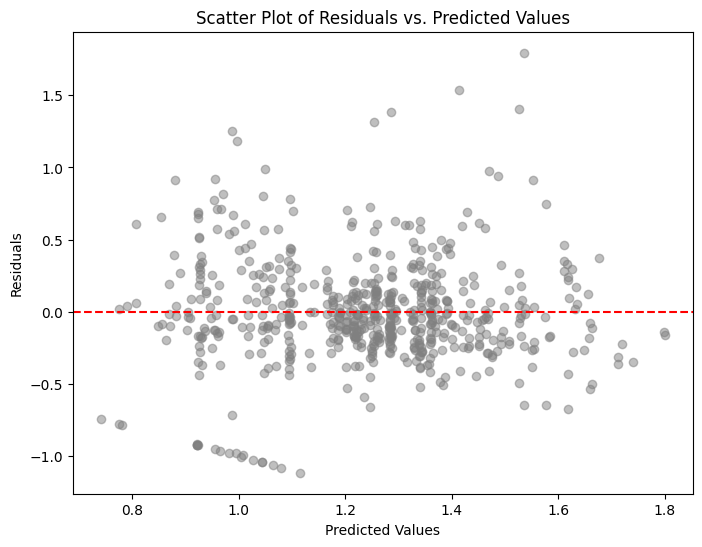

In [65]:
y_pred = model.predict(X)
residuals = y - y_pred

# Seaborn Q-Q plot using a histogram to check normality of residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, stat="density", color="grey", label="Residuals", bins=30)

mean_residuals = residuals.mean()
std_residuals = residuals.std()
x_values = np.linspace(residuals.min(), residuals.max(), 1000)
normal_dist = (1 / (std_residuals * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x_values - mean_residuals) / std_residuals) ** 2)

plt.plot(x_values, normal_dist, 'k', linewidth=2, label="Normal Distribution")

plt.title("Histogram of Residuals with Normal Distribution Curve")
plt.legend()
plt.show()

# Scatter
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, color='grey', alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Scatter Plot of Residuals vs. Predicted Values")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()
